# Imports

In [4]:
from __future__ import print_function, division
import torch
import torchvision
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import xml.etree.ElementTree as ET
import numpy as np
import time
import copy
import random
from itertools import chain
from tqdm.notebook import tqdm
import requests
from io import BytesIO

In [5]:
device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")

In [6]:
idx_label_dict = {1 : 'with_mask', 2 : 'mask_weared_incorrect', 3 : 'without_mask'}

# Functions

In [69]:
def xml_transform(xml_link):
    tree = ET.parse(xml_link)
    root = tree.getroot()
    img_name = root[1].text
    labels, boxes = [], []

    for obj in root.iter('object'):
        label_text = obj[0].text
        label = [idx for idx, label in idx_label_dict.items() if label == label_text][0]
        #label = 1 if obj[0].text=='with_mask' else 2 if obj[0].text=='without_mask' else 3 
        labels.append(label)
        box = [float(i.text) for i in obj[5]]
        boxes.append(box)

    target = {'boxes' : torch.as_tensor(boxes, dtype=torch.float32),
              'labels': torch.as_tensor(labels, dtype=torch.int64)}
    return img_name, target


def collate_fn(batch):
    return tuple(zip(*batch))

def plot_detection(img, info, with_text=False, conf_lvl=0.3, swap=True):
    fig, ax = plt.subplots()
    color_dict = {3: 'red', 1: 'green', 2: 'yellow'}
    if swap:
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)
        img = np.clip(img, 0, 1)
    ax.imshow(img)
    flag = False
    if 'scores' in info.keys():
        mask = info['scores'] >= conf_lvl
        confidences = info['scores'][mask]
        boxes = info['boxes'][mask]
        labels = info['labels'][mask]
        
        flag = True
    else:
        
        boxes = info['boxes']
        labels = info['labels']

    
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        width = y_max - y_min
        height = x_max - x_min
        label = idx_label_dict[int(labels[i])]
        color = color_dict[int(labels[i])]
        rect = patches.Rectangle((x_min, y_min), width, height,
                                 linewidth=2, edgecolor=color,
                                 facecolor='none')
        ax.add_patch(rect)
        if with_text:
            if flag:
                text = '{} {:.0f}%'.format(label, confidences[i]*100)
            else:
                text = '{}'.format(label)
            ax.text(x_min, y_min, text,
                    bbox=dict(facecolor='white', alpha=0.5))
    plt.show()



def train_val_split(root, val_size=.3):

    path = {os.path.join(root, link) for link in os.listdir(root)}
    val_size = int(len(path)*val_size)
    val_path = random.sample(path, val_size)
    train_path = list(path - set(val_path))
    return train_path, val_path


import torch
from torch import tensor
from torchvision.ops.boxes import box_iou

def calculate_iou(gt, pr):
    gt = align_coordinates(gt)
    pr = align_coordinates(pr)
    
    return box_iou(gt,pr)



def align_coordinates(boxes):
    """Align coordinates (x1,y1) < (x2,y2) to work with torchvision `box_iou` op
    Arguments:
        boxes (Tensor[N,4])
    
    Returns:
        boxes (Tensor[N,4]): aligned box coordinates
    """
    x1y1 = torch.min(boxes[:,:2],boxes[:, 2:])
    x2y2 = torch.max(boxes[:,:2],boxes[:, 2:])
    boxes = torch.cat([x1y1,x2y2],dim=1)
    return boxes


def get_mappings(iou_mat):
    mappings = torch.zeros_like(iou_mat)

    gt_count, pr_count = iou_mat.shape


    #first mapping (max iou for first pred_box)
    if not iou_mat[:,0].eq(0.).all():
        # if not a zero column
        mappings[iou_mat[:,0].argsort()[-1],0] = 1

    for pr_idx in range(1,pr_count):
        # Sum of all the previous mapping columns will let 
        # us know which gt-boxes are already assigned
        not_assigned = torch.logical_not(mappings[:,:pr_idx].sum(1)).long()

        # Considering unassigned gt-boxes for further evaluation 
        targets = not_assigned * iou_mat[:,pr_idx]

        # If no gt-box satisfy the previous conditions
        # for the current pred-box, ignore it (False Positive)
        if targets.eq(0).all():
            continue

        # max-iou from current column after all the filtering
        # will be the pivot element for mapping
        pivot = targets.argsort()[-1]
        mappings[pivot,pr_idx] = 1
    return mappings


def calculate_map(gt_boxes, pr_boxes, thresh=0.5):
    # sorting
    iou_mat = calculate_iou(gt_boxes,pr_boxes).to(device)
    gt_count, pr_count = iou_mat.shape
    
    # thresholding
    iou_mat = iou_mat.where(iou_mat>thresh,tensor(0.).to(device))
    
    mappings = get_mappings(iou_mat)
    
    # mAP calculation
    tp = mappings.sum()
    fp = mappings.sum(0).eq(0).sum()
    fn = mappings.sum(1).eq(0).sum()
    mAP = tp / (tp+fp+fn)
    
    return mAP


# Loading data

In [8]:
train_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])

val_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])

In [9]:
class MasksDataset(torch.utils.data.Dataset):

    def __init__(self, image_dir, annotation_path, transform):
        self.transform = transform
        self.image_dir = image_dir
        self.annotation_path = annotation_path

    def __len__(self):
        return len(self.annotation_path)

    def __getitem__(self, idx):

        ann_path = self.annotation_path[idx]
        img_name, target = xml_transform(ann_path)
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        return img, target


In [10]:
batch_size = 4
val_size = 0.2


train_path_an, val_path_an = train_val_split(root='../input/face-mask-detection/annotations/', val_size=val_size)

train_dataset = MasksDataset(image_dir='../input/face-mask-detection/images',
                       annotation_path=train_path_an,
                       transform=train_transform)

val_dataset = MasksDataset(image_dir='../input/face-mask-detection/images',
                       annotation_path=val_path_an,
                       transform=val_transform)

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                                collate_fn=collate_fn)

val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                                                collate_fn=collate_fn)


dataloaders = {'train': train_batch_gen,
               'val': val_batch_gen}
dataset_sizes = {'train' : len(train_dataset),
                 'val' : len(val_dataset)}

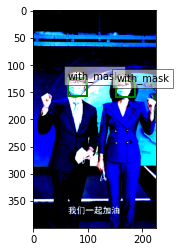

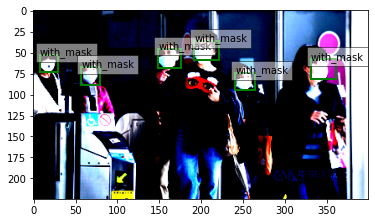

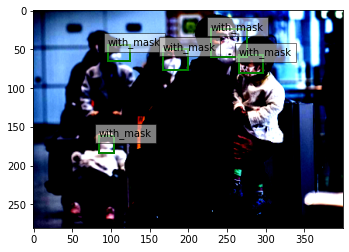

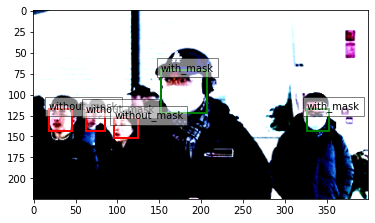

In [9]:
imgs, boxes = next(iter(val_batch_gen))
for img, info in zip(imgs, boxes):
    plot_detection(img, info, with_text=True)

# Train Faster RCNN Model

In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#load Faster R-CNN pre-trained on COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#Change the classifier head with a new one:
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 4 #(3 + background)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Starting epoch 0


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Starting epoch 1


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

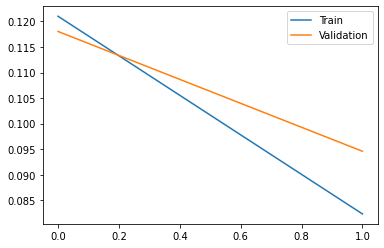

Starting epoch 2


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

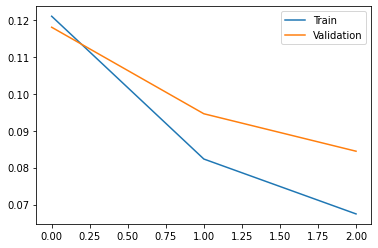

Starting epoch 3


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

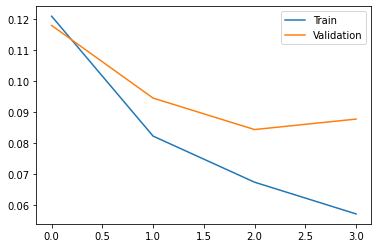

Starting epoch 4


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

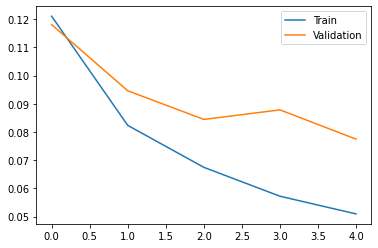

Starting epoch 5


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

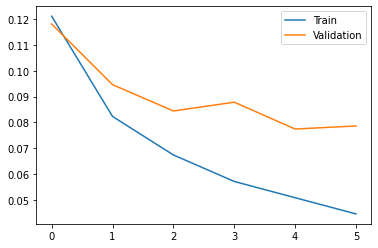

In [44]:
number_epochs = 6   #TODO: Choose
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9)#TODO: Choose, momentum=#TODO: Choose)

train_loss = []
val_loss = []

for epoch in range(number_epochs):
  print(f"Starting epoch {epoch}")

  if epoch > 0:
    plt.figure()

  model.train()
  train_loss.append(0)
  for images, labels in tqdm(train_batch_gen):
    images = list(image.to(device) for image in images)
    labels = [{k: v.to(device) for k, v in t.items()} for t in labels]
    #print(len(images), images[0].shape, images[1].shape)

    loss_dict = model(images, labels)

    #print(type(loss_dict), len(loss_dict), loss_dict, )
    #print(loss_dict.values() )

    losses = sum(loss for loss in loss_dict.values())
    optimizer.zero_grad()
    losses.backward()
    optimizer.step() 

    train_loss[epoch] += losses.cpu().data
  train_loss[epoch] /= len(train_dataset)

  if epoch > 0:
    train_plt, = plt.plot(train_loss, label = 'Train')

  #TODO: compute the loss on the validation set and fill val_loss[epoch]
  #model.eval()
  val_loss.append(0)
  with torch.no_grad():
    for images, labels in tqdm(val_batch_gen):
      images = list(image.to(device) for image in images)
      labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

      loss_dict = model(images, labels)
      #print(type(loss_dict), len(loss_dict), loss_dict)
      losses = sum(loss for loss in loss_dict.values())
      val_loss[epoch] += losses.cpu().data
    val_loss[epoch] /= len(val_dataset)
    

  if epoch > 0:
    val_plt, = plt.plot(val_loss, label = 'Validation')
    plt.legend(handles=[train_plt, val_plt])
    plt.show()

In [45]:
torch.save(model.state_dict(), 'model_g1.pt')

# Model testing

In [ ]:
model.load_state_dict(torch.load('../input/model-g1pt/model_g1.pt'))

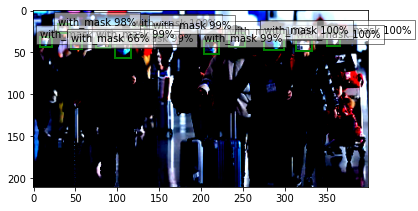

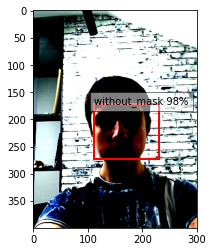

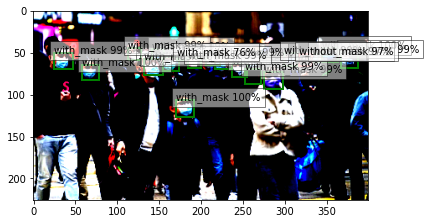

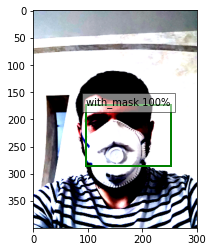

In [51]:
model.eval()
imgs, targets = next(iter(dataloaders['val']))
inputs = list(img.to(device) for img in imgs)
targets = [{k:v.to(device) for k,v in t.items()} for t in targets] 
preds = model(inputs)

for img, info in zip(imgs, preds):
    plot_detection(img, info, conf_lvl=0.5, with_text=True)

# Calculating maP

In [15]:
maP_list_train = []

model.eval()
for inputs, targets in dataloaders['val']:
    inputs = list(img.to(device) for img in inputs)
    targets = [{k:v.to(device) for k,v in t.items()} for t in targets] 
    preds = model(inputs)
    maP_list_train.append(torch.Tensor([calculate_map(target['boxes'], pred['boxes']) for target, pred in zip(targets, preds)]))

In [20]:
maP_mean_for_batch = [float(map_tens.mean()) for map_tens in maP_list_train]
maP_mean_for_batch

[0.7583333849906921,
 0.7802631855010986,
 0.9074074029922485,
 0.8888888955116272,
 0.549074113368988,
 0.6237373948097229,
 1.0,
 0.7202380895614624,
 0.828125,
 0.7633928656578064,
 0.569940447807312,
 0.6458333730697632,
 0.6500000357627869,
 0.4863782227039337,
 0.7135416865348816,
 0.6753246784210205,
 0.884615421295166,
 0.6208333373069763,
 0.6041666865348816,
 0.6770833730697632,
 0.4297619163990021,
 0.646212100982666,
 0.6136363744735718,
 0.875,
 0.6083332896232605,
 0.8500000238418579,
 0.7124999761581421,
 0.8482142686843872,
 0.7652310729026794,
 0.6585081815719604,
 0.7500000596046448,
 0.8888888955116272,
 0.8620689511299133,
 0.828125,
 0.8035714626312256,
 0.9375,
 0.5626984238624573,
 1.0,
 0.800000011920929,
 0.45179083943367004,
 0.5532531142234802,
 0.9444444179534912,
 0.5833333730697632]

In [21]:
np.mean(maP_mean_for_batch)

0.728377891834392

# Test on random images

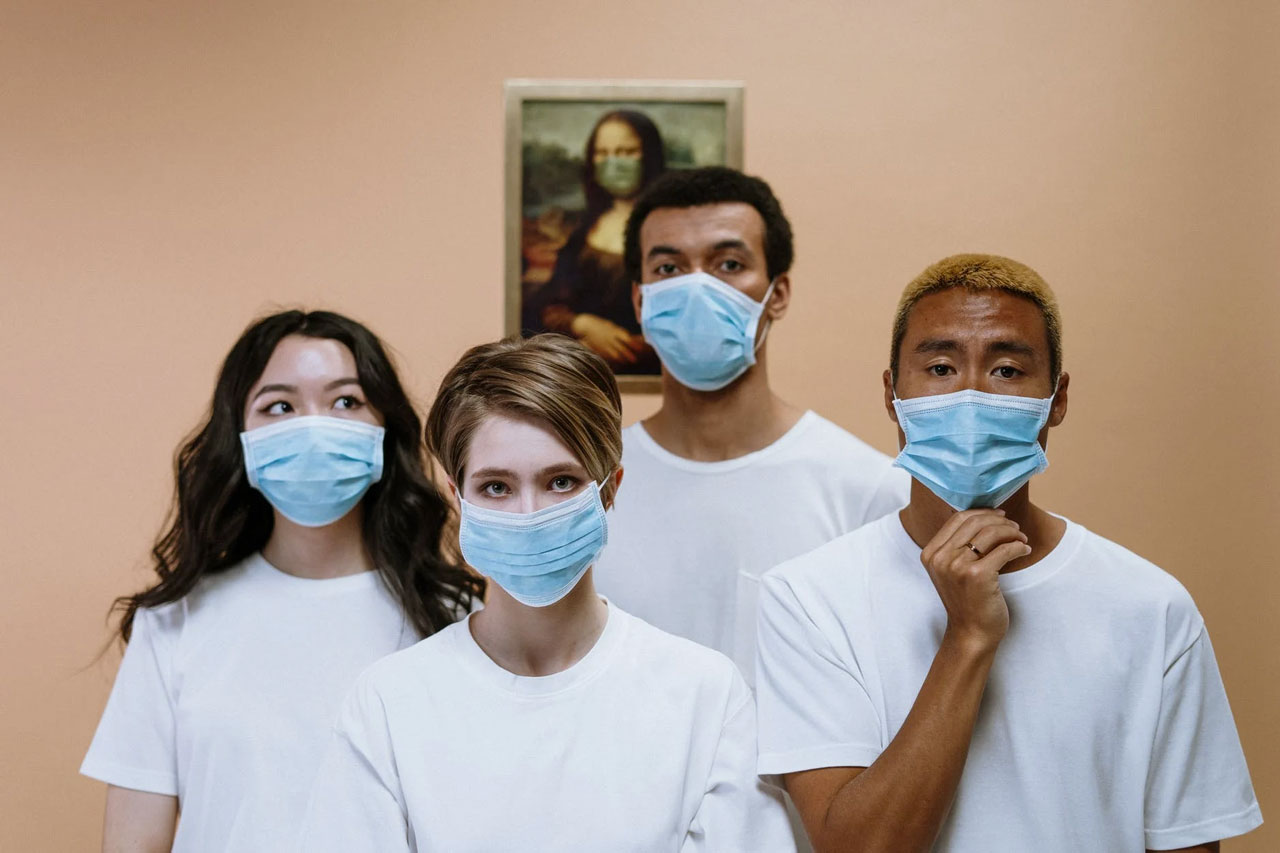

In [71]:
from PIL import Image
import requests
from io import BytesIO

url = "https://announcement.ph/wp-content/uploads/2020/04/Facemask-required.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

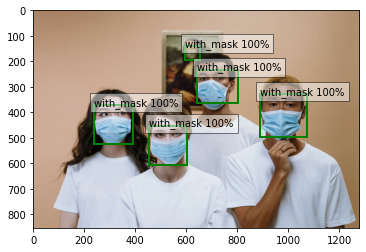

In [72]:
img_t = val_transform(img).unsqueeze_(0).to(device)
pred = model(img_t)
plot_detection(img, pred[0], conf_lvl=0.5, with_text=True, swap=False)

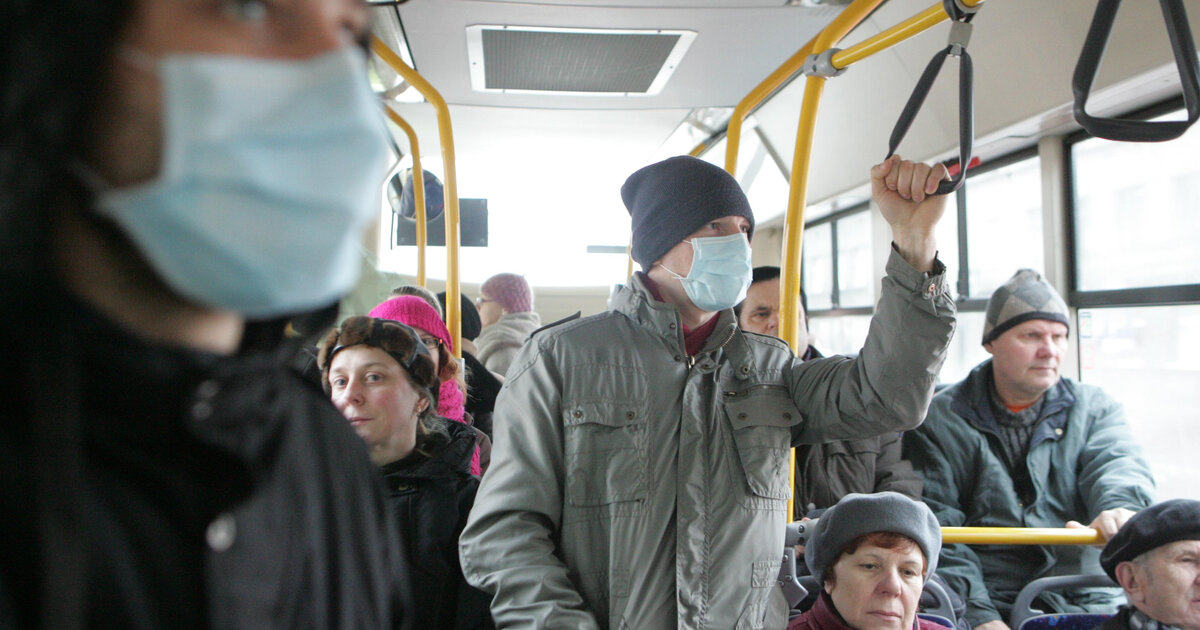

In [73]:
from PIL import Image
import requests
from io import BytesIO

url = "https://cdn.readovka.net/n/1139886/1200x630/86470db3f4.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img


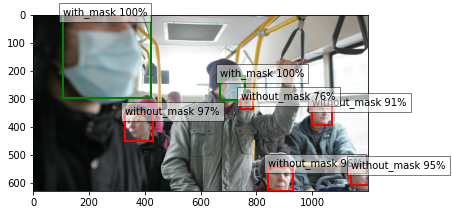

In [74]:
img_t = val_transform(img).unsqueeze_(0).to(device)
pred = model(img_t)
plot_detection(img, pred[0], conf_lvl=0.5, with_text=True, swap=False)